In [22]:
import pandas as pd
import numpy as np
from pygobnilp.gobnilp import Gobnilp
import pgmpy
import itertools
from pgmpy.estimators.CITests import pearsonr
from pgmpy.estimators.CITests import chi_square
import networkx as nx
import time
import collections

In [23]:
def csv_format_discrete(csv_file):
    df = pd.read_csv(csv_file, sep="\s+")
    return df.drop([0])

#returns the csv_file in a pandas dataframe, formatted properly, discrete dataset only

In [24]:
#small network : n <= 20 nodes, medium network: 20 <= n <= 50 , large: 50 <= n <= 100, ... 
df_asia = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat")
df_child = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\child.dat")
df_insurance = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\insurance.dat")
df_water = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\Water_1000.dat")
df_alarm = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_10000.dat")
df_barley = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\barley.dat")
df_hailfinder = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\hailfinder.dat")
df_hepar2 = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\hepar2.dat")
df_andes = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\andes.dat")
df_link = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\link.dat")
df_pathfinder = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\pathfinder.dat")
df_munin2 = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\munin2.dat")

### chi-squared test

In [35]:
#0th order chi2 test
def chi2bool(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    chi2 = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        chi = chi_square(X=i, Y=j, Z=[], data=df, significance_level=rho)
        chi2.append((i,j,chi))
    true_0 = [x for x in chi2 if True in x]
    false_0 = [x for x in chi2 if False in x]
    return true_0, false_0

### graph

In [36]:
def Graph(df):
    G = nx.Graph()
    v = list(df)
    for i in v:
        G.add_node(i)
    k = list(itertools.combinations(v,2))
    for i,j in k:
        G.add_edge(i,j)
#     print(G)
    return(G)

In [37]:
import networkx as nx

Graph with 3 nodes and 2 edges


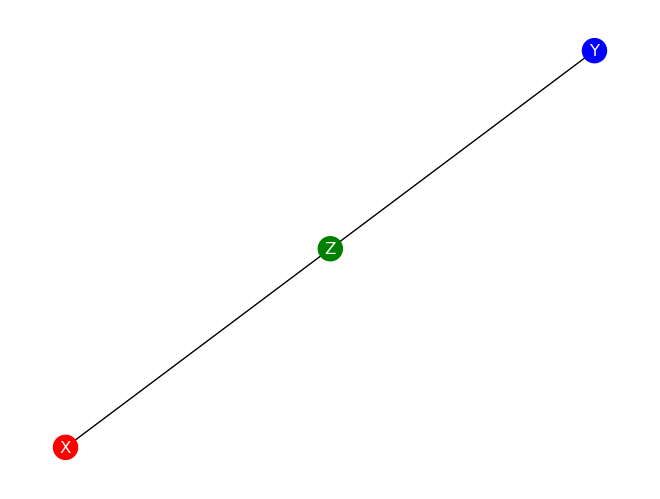

In [38]:
g = nx.Graph()
g.add_node('X', color='red')
g.add_node('Y', color='blue')
g.add_node('Z', color='green')
g.add_edge('X', 'Z')
g.add_edge('Y', 'Z')
colors = [node[1]['color'] for node in g.nodes(data=True)]
print(g)
nx.draw(g, node_color=colors, with_labels=True, font_color='white')


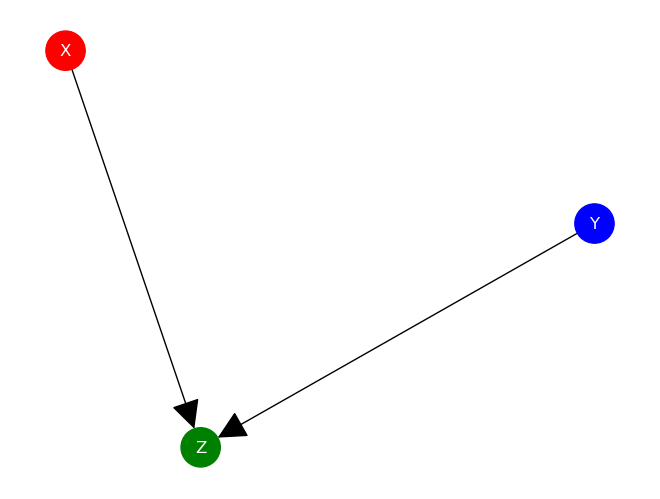

In [39]:
G = nx.DiGraph()
G.add_node('X', color='red')
G.add_node('Y', color='blue')
G.add_node('Z', color='green')
G.add_edges_from([('X', 'Z'), ('Y', 'Z')])
colors = [node[1]['color'] for node in G.nodes(data=True)]
nx.draw(G, node_color=colors, with_labels=True, font_color='white', arrowsize=45, node_size=800)


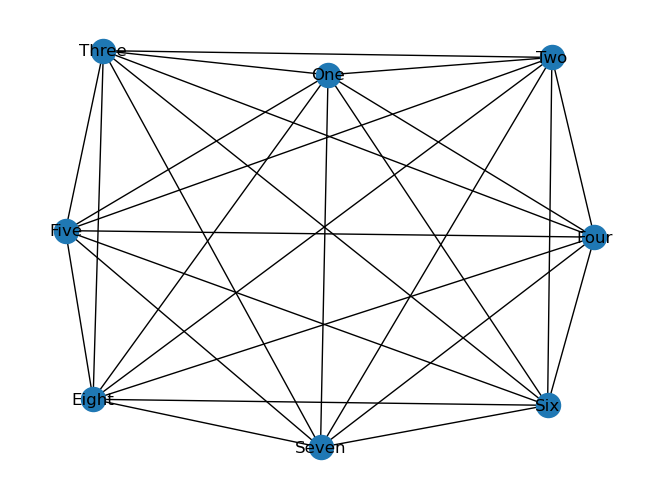

In [63]:
nx.draw(g_asia, with_labels=True)

In [64]:
def PC_0(df, rho, G):
    '''
    finds 0th order conditional independencies (CI) between each node, if True then remove an edge 
    '''
    ind_0 = [x[:2] for x in chi2bool(df, rho)[0]]
    for i,j in ind_0:
        G.remove_edge(i,j)
#     print('the number of edges removed is:' , len(ind_0))
#     print(G)
    return G, ind_0

In [67]:
g_asia = Graph(df_asia)
k = PC_0(df_asia, 0.05, g_asia)

In [68]:
nx.draw(k[1], 

(<networkx.classes.graph.Graph at 0x1fa50b2c4c0>,
 [('One', 'Four'),
  ('One', 'Five'),
  ('Two', 'Four'),
  ('Two', 'Five'),
  ('Three', 'Four'),
  ('Four', 'Six'),
  ('Four', 'Seven'),
  ('Four', 'Eight')])

### adjacency finder

In [41]:
def find_adjacency_XY(graph):    
    '''
    finds adjacencies of XY in the graph
    '''
    test_list = []
    graph_list = list(graph.edges)
    for i,j in graph_list:
        test_list.append((i, j, list(graph.edges(i)), list(graph.edges(j))))
    n = 0
    N = len(test_list)
    edge_XY = []
    while n < N:
        ##
        adjacent_X = []
        adjacent_Y = []
        X, Y = test_list[n][0], test_list[n][1]
        k_X, k_Y = test_list[n][2], test_list[n][3]
        edge_X = [x for x in k_X if x[1] != Y]
        edge_Y = [x for x in k_Y if x[1] not in (y[1] for y in k_X) and x[1] != X]
        for x in edge_X:
            adjacent_X.append(x[1])
        for y in edge_Y:
            adjacent_Y.append(y[1])
        adjacent_XY = adjacent_X + adjacent_Y
        len_XY = len(adjacent_XY)
        edge_XY.append((X, Y, adjacent_XY, len_XY))
#         print(edge_XY)
        n += 1
    return edge_XY

### obtaining combinations and data preprocessing

In [42]:
def get_combinations(this_list, df, N_0, rho):
    '''
    probably the main function of everything
    given a list in the form adj[0] finds its CIs
    '''
    adjacency = this_list[2]
    len_adjacency = len(adjacency)
    n = 1
    combinations = []
    while n <= N_0:
        k = list(itertools.combinations(adjacency, n))
        t = list(list(x) for x in k)
        for i in t:
            chi2 = chi_square(X=this_list[0], Y=this_list[1], Z=i, data=df, significance_level=rho)
            if chi2 == True:
                combinations.append((this_list[0], this_list[1], i, chi2))
                return combinations
        n += 1

In [43]:
def combinations_adjacents(adj, df, N, rho):
    '''
    one of the main functions
    adj = output from find_adjacency_XY
    N = stopping point for how many combinations you want
    output: obtains the combinations of n=1,2,...N of the whole list in an unordered manner (see open_list)
    '''
    len_adjacents = len(adj)
    combinations = []
    for i in range(len_adjacents):
        t = get_combinations(adj[i], df, N, rho)
        combinations.append(t)
    return combinations

### chi2 test 

In [44]:
def PC_final(graph, adj, N, df, rho):
    '''
    graph = nx.graph
    adj = output from find_adjacency_XY
    N = order of conditional independence
    df = dataframe
    rho = significance_level
    '''
    X_Y = []
    combinations_chi2 = combinations_adjacents(adj, df, N, rho)
    for i in combinations_chi2:
        if i != None:
            for j in i:
                X_Y.append((j[0], j[1]))
    for i in X_Y:
        graph.remove_edge(i[0], i[1])
    return graph, X_Y

In [45]:
def PC_SL(df, N, rho):
    '''
    Input: df - a pandas dataframe, N = CI order, rho = significance threshold (alpha) but i denote it by rho
    returns 2 components, the graph G as index 0 and the 
    '''
    ### initialize the graph ###
    g = Graph(df)
    
    ### finds 0th order CI ###
    g_0 = PC_0(df, rho, g)
    # worth noting that g_0 is a tuple, g_0[0] = graph, g_0[1] = list of 0th order CI values
    
    ### finds adjacents ###
    adj = find_adjacency_XY(g_0[0])
#     return adj
    #combinations_adjacnents#
    k = combinations_adjacents(adj, df, N, rho)
    
    ### final part ###
    ind = []
    for i in k:
        if i != None:
#             print(i)
            for j in i:
                ind.append((j[0], j[1]))
    print('the number of restricted edges is :', len(g_0[1] + ind))
    return g_0[1] + ind

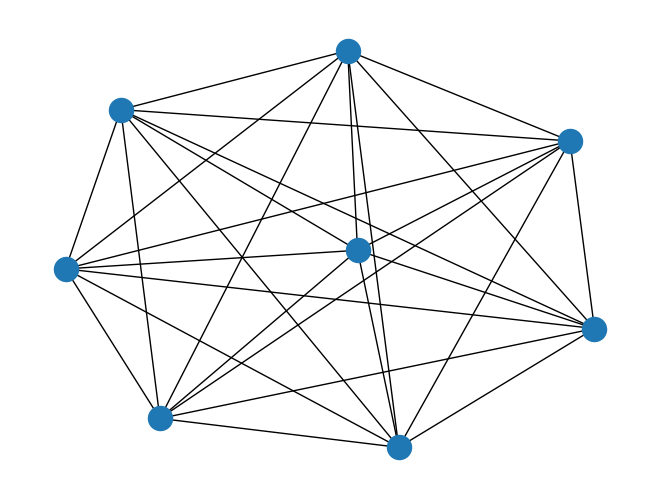

In [47]:
nx.draw(Graph(df_asia))

In [ ]:
%%time
toc = time.time()
'''
restrict phase
'''
m = Gobnilp()
for i in PC_SL(df_asia, 1, 0.05):
    m.add_forbidden_adjacency((i[0], i[1]))
'''
score phase
'''
#score phase##
m.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\child.dat')
tic = time.time()
print('the time taken to learn the network is:', tic - toc, 'seconds')

In [ ]:
%%time
toc = time.time()
'''
restrict phase
'''
j = Gobnilp()
for i in PC_SL(df_asia, 1, 0.99):
    j.add_forbidden_adjacency((i[0], i[1]))
'''
score phase
'''
#score phase##
j.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_1000.dat')
tic = time.time()
print('the time taken to learn the network is:', tic - toc, 'seconds')

### show the effeect of trading the significance threshold and the effect of the execution and the model evaluation

In [ ]:
k = Gobnilp()
k.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\water_1000.dat')


In [ ]:
j_0.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\andes.dat')

In [ ]:
%%time
toc = time.time()
'''
restrict phase
'''
j_0 = Gobnilp()
for i in PC_SL(df_andes, 1, 0.05):
    j_0.add_forbidden_adjacency((i[0], i[1]))
'''
score phase
'''
#score phase##
j_0.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\andes.dat')
tic = time.time()
print('the time taken to learn the network is:', tic - toc, 'seconds')

In [ ]:
'''
number of edges removed -> significance threshold, order of CI (n), number of variables, parent limit set

runtime -> order of CI (n), number of variables, number of data points per variable, parent limit,  
'''
None

### conclusion: what is the story behind your work, what lessons can be learned?

In [ ]:
%%time
toc0 = time.time()
h = Gobnilp()
h.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\Water_1000.dat')
tic0 = time.time()
print(tic0-toc0)